<a href="https://colab.research.google.com/github/Jungin1020/Aiffel_exp/blob/main/2022_02_17_exp_11_ARIMA_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

###1. 데이터 준비~
종가만 가져오기

In [63]:
dataset_filepath = '/content/drive/MyDrive/aiffel/stock_prediction/data/068270.KS.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-02-15    326470.59375
2021-02-16    318627.43750
2021-02-17    315196.09375
2021-02-18    308333.34375
2021-02-19    312254.90625
Name: Close, dtype: float64

###2. 전처리 수행

In [64]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치가 없다

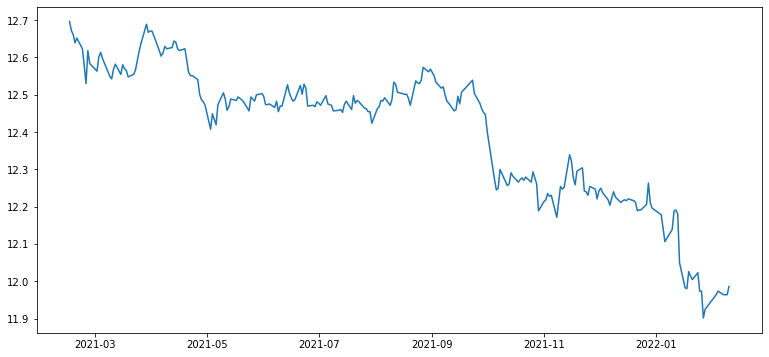

In [130]:
ts_log = np.log(ts)
plt.plot(ts_log)

로그 변환과 그래프 확인

###3. 시계열 안정성 분석(Stationary 여부를 체크하는 통계적 방법)
-----
###구간 통계치를 Rolling Statistics를 시각화 해보자
현재 타임 스텝부터 window에 주어신 타임스텝 이전까지의

구간 평균 rolling mean

표준편차 rolling std

In [66]:
def plot_rolling_statistics(timeseries, window=12):
  rolmean = timeseries.rolling(window=window).mean()
  rolstd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling mean')
  #std = plt.plot(rolstd, color='black', label='Rolling std')

  plt.legend(loc='best')
  plt.title('Rolling Means & Standard Deviation')
  plt.show(block=False)

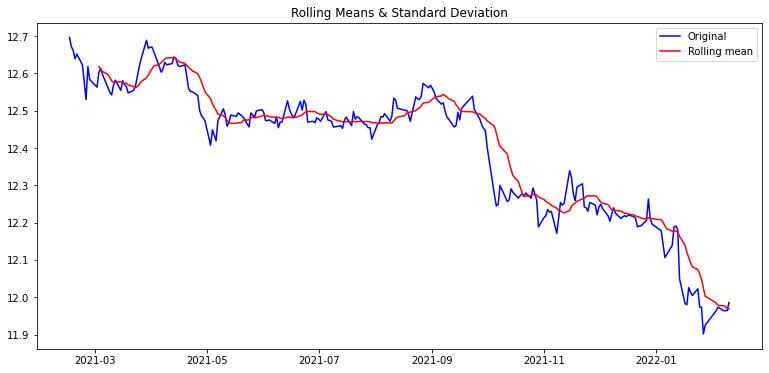

In [131]:
plot_rolling_statistics(ts_log, window=12)

### Augmented Dickey-Fuller Test (ADF Test) 
-----
이 시계열 데이터가 안정적이지 않다 라는 귀무가설 Null Hypothesis 를 세우고

통계적 가설 검증 과정을 통해 이 귀무가설이 기각될 경우

이 시계열이 안정적이다 라는 대립가설 Alternative Hypothesis 를 채택
------
statsmodels 패키지에서 제공하는 'adfuller' 메서드를 이용해 쉽게 Test 결과 사용
강력한 통계 패키지

In [68]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries, autolag='AIC')

  print('Result of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Odservations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

In [133]:
augmented_dickey_fuller_test(ts)

Result of Dickey-Fuller Test:
Test Statistic                  -1.083635
p-value                          0.721554
#Lags Used                       0.000000
Number of Odservations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


In [70]:
augmented_dickey_fuller_test(ts_log)

Result of Dickey-Fuller Test:
Test Statistic                  -0.060993
p-value                          0.953188
#Lags Used                       3.000000
Number of Odservations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


p-value가 1에 가까우니 stationary하지 않다

그런데 log 변환하지 않았을 때 p-value가 더 낮다??

일단은 로그변환한 데이터로 진행을 해본다

###안정적 Stationary 하지 않은 시계열 데이터를 Stationary하게 만들어보자 (1)

###moving average 제거 - trend 상쇄하기
moving average(rolling mean)를 구해서 ts_log에서 뺴주면 어떨까?

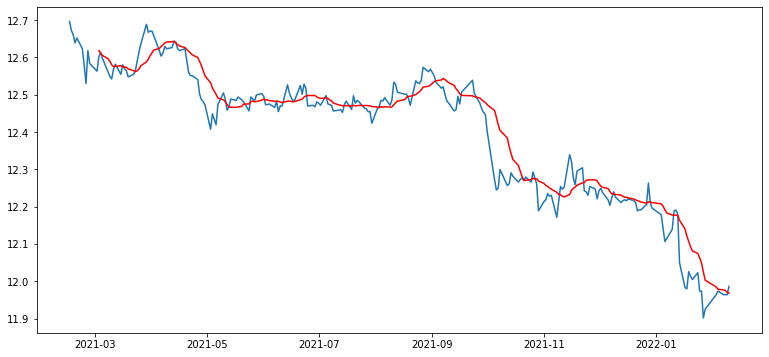

In [135]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [136]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(15)

Date
2021-02-15         NaN
2021-02-16         NaN
2021-02-17         NaN
2021-02-18         NaN
2021-02-19         NaN
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26         NaN
2021-03-02         NaN
2021-03-03   -0.016358
2021-03-04    0.002038
2021-03-05   -0.008155
2021-03-08   -0.035296
Name: Close, dtype: float64

window=12라서 앞에 11개의 평균이 계산되지 않아 NAN이 됨

dropna 해주자

In [137]:

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-03-03   -0.016358
2021-03-04    0.002038
2021-03-05   -0.008155
2021-03-08   -0.035296
2021-03-09   -0.039916
2021-03-10   -0.037782
2021-03-11   -0.007286
2021-03-12    0.005993
2021-03-15   -0.023356
2021-03-16    0.005435
2021-03-17   -0.003606
2021-03-18   -0.008873
2021-03-19   -0.021623
2021-03-22   -0.009780
2021-03-23    0.004784
Name: Close, dtype: float64

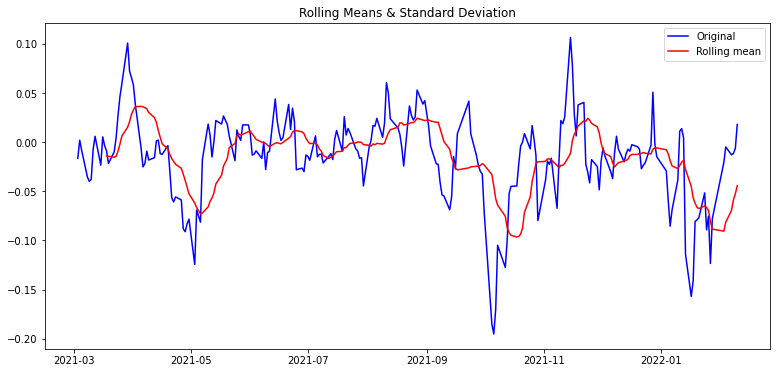

In [138]:
plot_rolling_statistics(ts_log_moving_avg)

In [139]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Result of Dickey-Fuller Test:
Test Statistic                  -5.187968
p-value                          0.000009
#Lags Used                       1.000000
Number of Odservations Used    232.000000
Critical Value (1%)             -3.458855
Critical Value (5%)             -2.874080
Critical Value (10%)            -2.573453
dtype: float64


p-value가 엄청 떨어졌다!!

##안정적 Stationary 하지 않은 시계열 데이터를 Stationary하게 만들어보자 (2)
2. 시계열 분해
statsmodels 라이브러리 안에 seosonal_decompose 메서드를 사용해 시계열 안에 존재하는 trend, seosonality를 분리할 수 있다.

위에 과정을 거치치 않아도 안정적으로 시계열 분리

In [140]:
type(ts_log)

pandas.core.series.Series

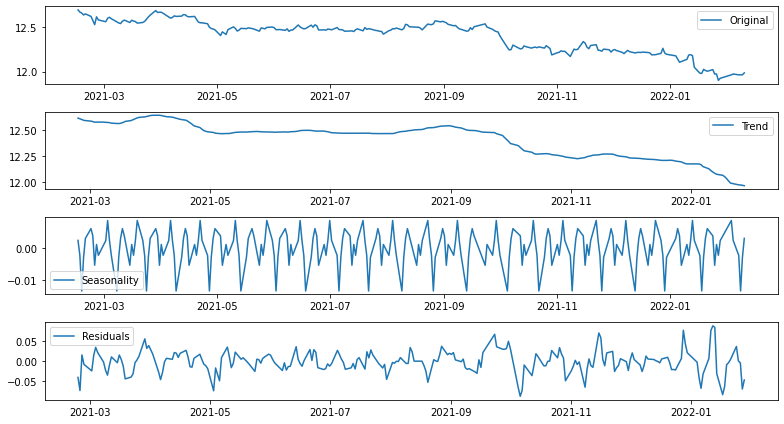

In [141]:


from statsmodels.tsa.seasonal import seasonal_decompose
#decomposition = seasonal_decompose(ts)
decomposition = seasonal_decompose(ts_log, period = 12)

trend = decomposition.trend #추세
seasonal = decomposition.seasonal #계절성
residual = decomposition.resid #원본(로그변환) - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

seasonal_decompose관련 에러가 나서 freq 파라미터를 추가해줬더니 정상 작동한다.

decomposition = seasonal_decompose(ts, freq = 12)

근데 런타임 다시 돌리니까 또 에러가 나서 freq를 period로 바꿨다.

이게 뭐람!!

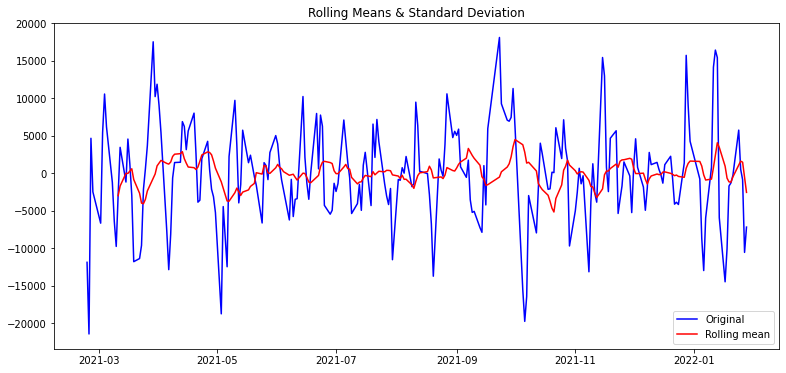

In [81]:
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [82]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Result of Dickey-Fuller Test:
Test Statistic                -7.690078e+00
p-value                        1.426990e-11
#Lags Used                     1.000000e+01
Number of Odservations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


굉장이 작은 p-value

###ARIMA 모델을 배워보자!!
앞서 배운 원리로 시계열 데이터 예측 모델을 만들 수 있다

AR - residual에 해당

MA - trend 에 해당

I - seosonality에 해당

###ARIMA의 파라미터 -p d q
p: 자기회귀 모형 AR 의 시차

d: 차분누적 I 의 횟수

q: 이동평균 모형 MA 의 시차

###p와 q를 구해보자

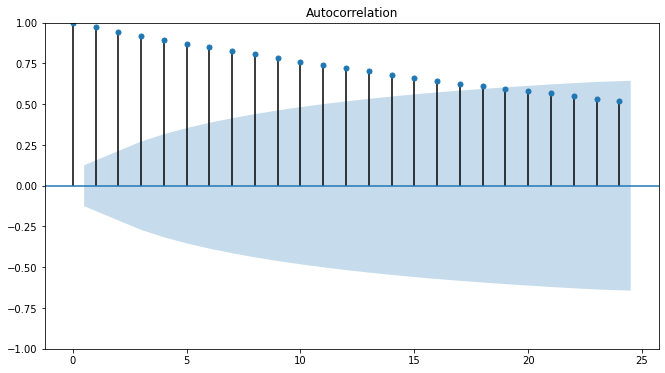

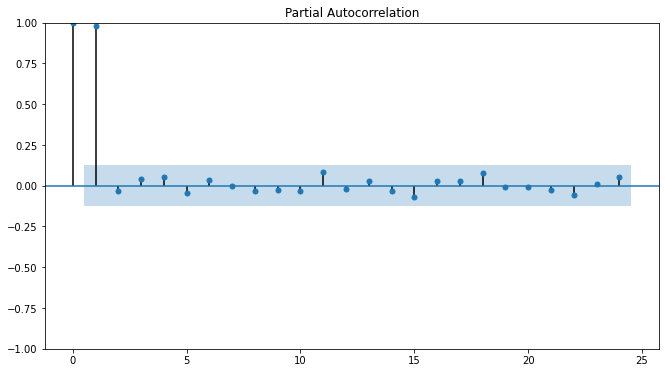

In [142]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log) #autocorrelation 그래프 그리기
plot_pacf(ts_log) #partial autocorrelation 그래프 그리기
plt.show()

ACF - 시차 q 이후에 0

PACF - 시차 p 이후에 0

p=1에 적합(2이상일 떈 0에 가까우니까)

p + q < 2, p * q = 0

q=0이라고 하자

##d를 구해보자

Result of Dickey-Fuller Test:
Test Statistic                -1.066362e+01
p-value                        4.343293e-19
#Lags Used                     2.000000e+00
Number of Odservations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


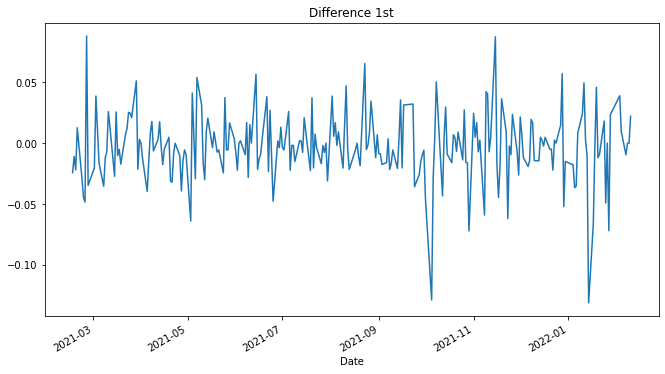

In [143]:
#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Result of Dickey-Fuller Test:
Test Statistic                -7.194491e+00
p-value                        2.454759e-10
#Lags Used                     1.400000e+01
Number of Odservations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


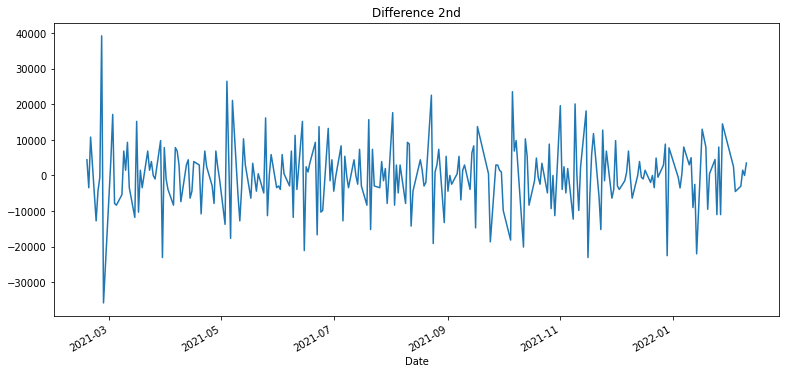

In [85]:
#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

d 값을 바꿔가면서 최적값 구해봐라~

##학습 데이터 분리
시계열 데이터니까 가장 나중 데이터를 테스트에 써야한다!

학습, 테스트 비율은 9:1

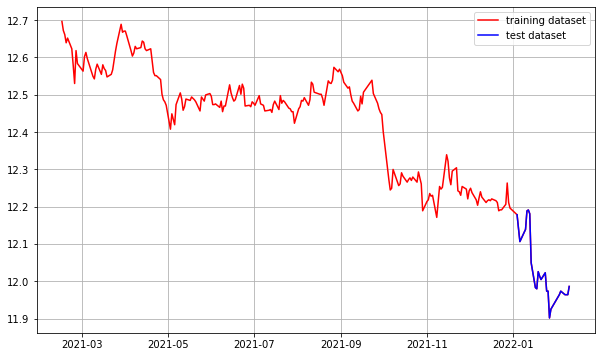

In [144]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r',label='training dataset') #train_data 이용하면 끊어져 보여서 ts_log 쓴답니다~
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [145]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-15    12.696095
2021-02-16    12.671778
Name: Close, dtype: float64
(220,)
(25,)


##모델 훈련과 추론

In [97]:
#!pip install --upgrade statsmodels

In [164]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1,1,0)) #파라미터 p,d,q
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 486.292
Date:                Thu, 17 Feb 2022   AIC                           -968.585
Time:                        14:37:55   BIC                           -961.807
Sample:                             0   HQIC                          -965.847
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0499      0.058     -0.864      0.388      -0.163       0.063
sigma2         0.0007   4.29e-05     16.070      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.04   Jarque-

ts를 log 변환 안했더니 Log Likelihood가 곤두박질 치길래 로그변환 해줬다. 그런데....



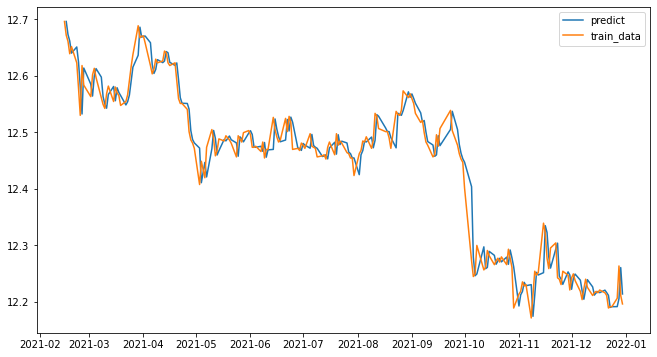

In [151]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

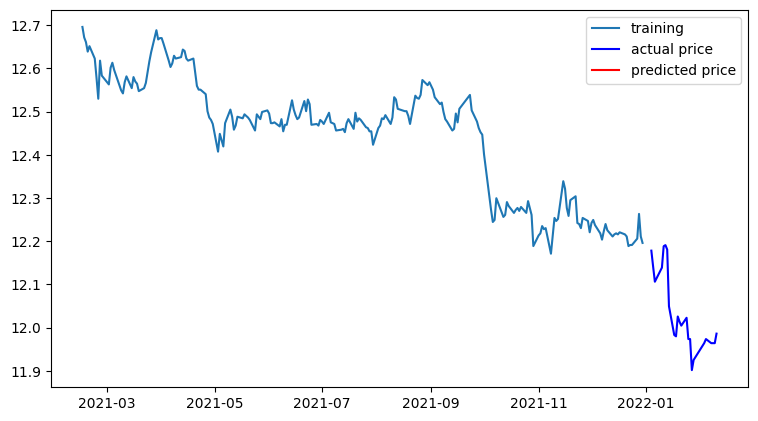

In [162]:
model = ARIMA(train_data, order=(11,1,0)) #p값 다르게
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), h=10, alpha=0.05)
#판다스 시리즈로
fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

파라미터를 아무리 바꿔도 예측값이 안나온다!!!

밑에 mean_squared_error도 NAN 값이라고 에러가 뜬다..

In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ',rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

ValueError: ignored

SARIMA를 써볼까?

In [165]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data, order=(1,1,0)) #파라미터 p,d,q
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 486.292
Date:                Thu, 17 Feb 2022   AIC                           -968.585
Time:                        14:40:09   BIC                           -961.807
Sample:                             0   HQIC                          -965.847
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0499      0.058     -0.864      0.388      -0.163       0.063
sigma2         0.0007   4.29e-05     16.070      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.04   Jarque-

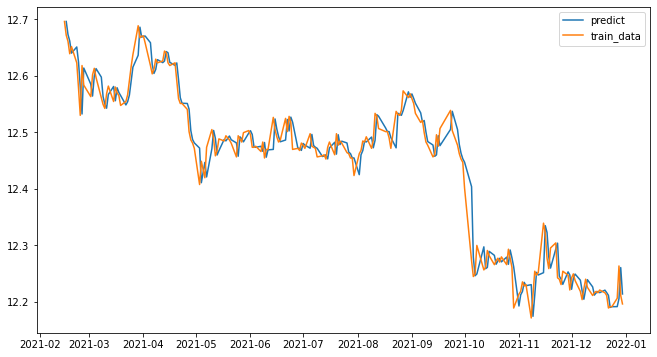

In [166]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

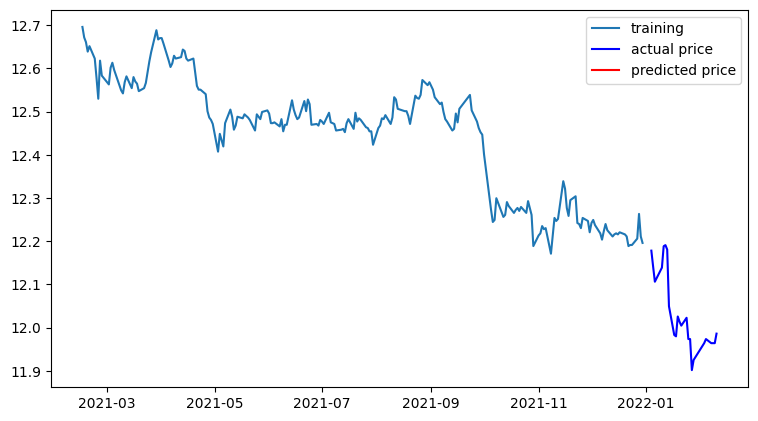

In [168]:
model = SARIMAX(train_data, order=(1,1,0)) #p값 다르게
fitted_m = model.fit(disp=1,solver='powell')
fc = fitted_m.forecast(len(test_data), h=10, alpha=0.05)
#판다스 시리즈로
fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

그래도 나오질 않는다...

다른 데이터로 해본다

믿는다 디즈니


In [170]:
dataset_filepath = '/content/drive/MyDrive/aiffel/stock_prediction/data/DIS.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2021-02-11    190.910004
2021-02-12    187.669998
2021-02-16    186.350006
2021-02-17    186.440002
2021-02-18    183.000000
Name: Close, dtype: float64

In [171]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

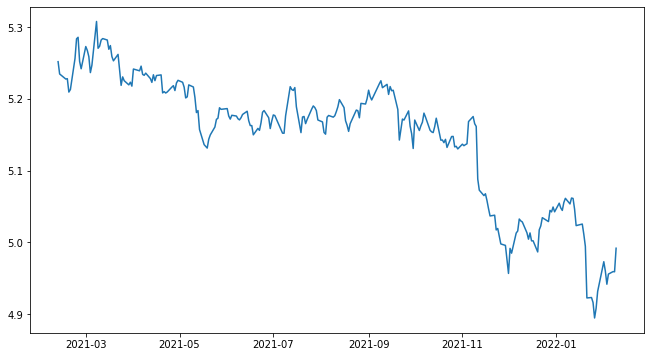

In [172]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [173]:
augmented_dickey_fuller_test(ts_log)

Result of Dickey-Fuller Test:
Test Statistic                  -1.080762
p-value                          0.722683
#Lags Used                       0.000000
Number of Odservations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


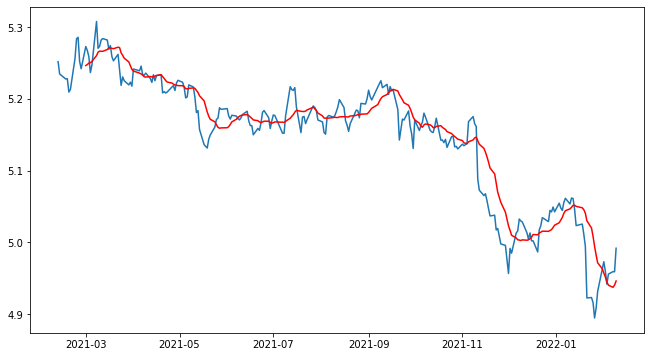

In [174]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

왜 다 곤두박질 치는지...?

In [175]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2021-03-01    0.026442
2021-03-02    0.019782
2021-03-03    0.009068
2021-03-04   -0.013927
2021-03-05   -0.005129
2021-03-08    0.047527
2021-03-09    0.005401
2021-03-10    0.006802
2021-03-11    0.015573
2021-03-12    0.017803
2021-03-15    0.013287
2021-03-16   -0.001865
2021-03-17    0.003159
2021-03-18   -0.011401
2021-03-19   -0.016861
Name: Close, dtype: float64

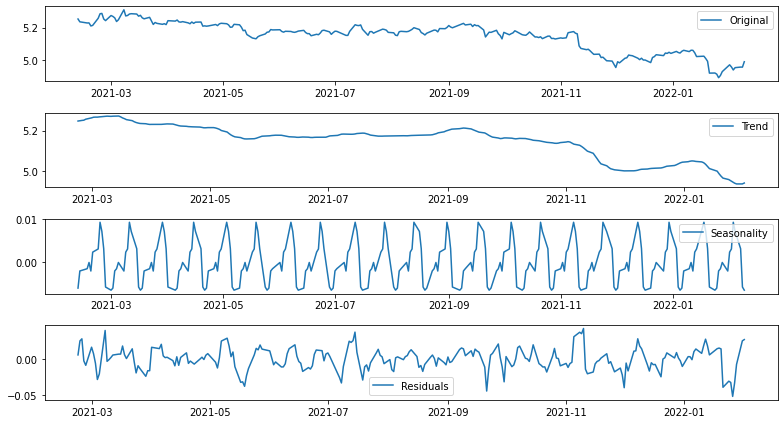

In [176]:
decomposition = seasonal_decompose(ts_log, period = 12)

trend = decomposition.trend #추세
seasonal = decomposition.seasonal #계절성
residual = decomposition.resid #원본(로그변환) - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

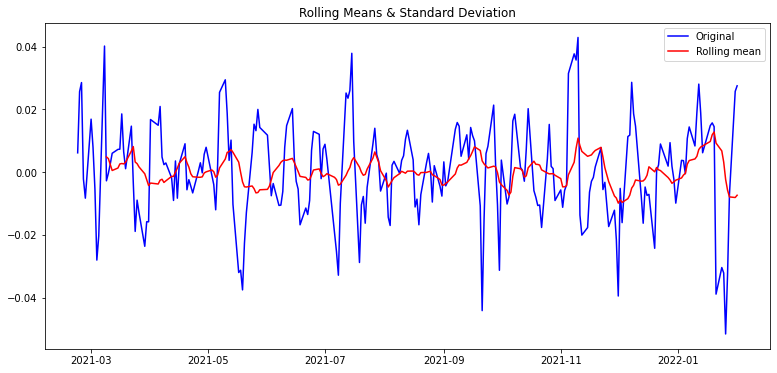

In [177]:
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [178]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Result of Dickey-Fuller Test:
Test Statistic                -9.300371e+00
p-value                        1.116704e-15
#Lags Used                     4.000000e+00
Number of Odservations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


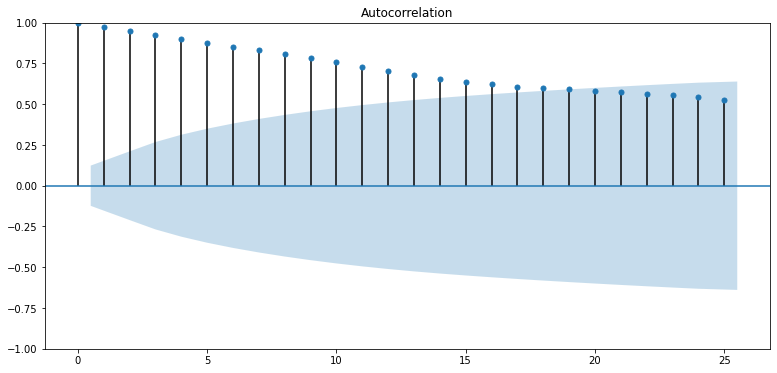

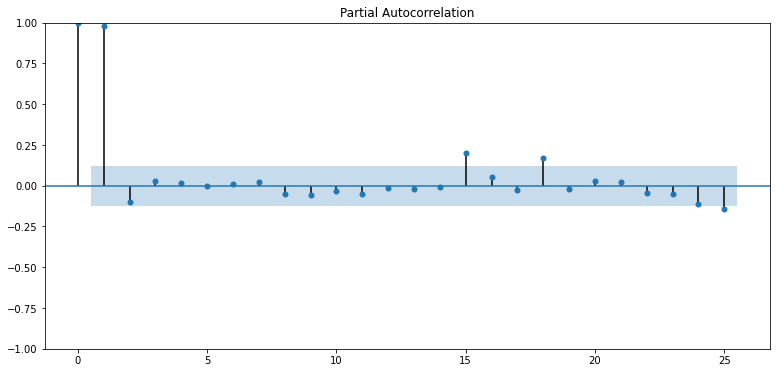

In [179]:
plot_acf(ts_log) #autocorrelation 그래프 그리기
plot_pacf(ts_log) #partial autocorrelation 그래프 그리기
plt.show()

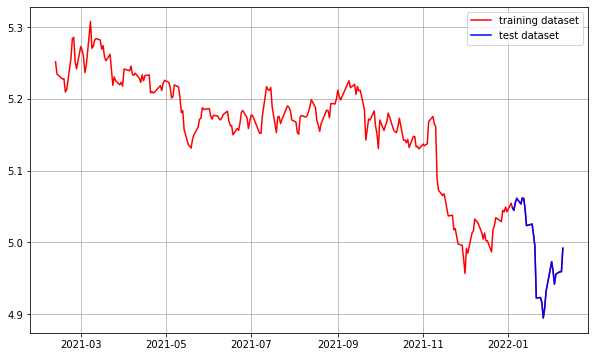

In [180]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r',label='training dataset') #train_data 이용하면 끊어져 보여서 ts_log 쓴답니다~
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [181]:
model = ARIMA(train_data, order=(1,1,0)) #파라미터 p,d,q
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 625.626
Date:                Thu, 17 Feb 2022   AIC                          -1247.253
Time:                        14:50:04   BIC                          -1240.420
Sample:                             0   HQIC                         -1244.495
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0197      0.055      0.358      0.721      -0.088       0.128
sigma2         0.0002   1.29e-05     17.455      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

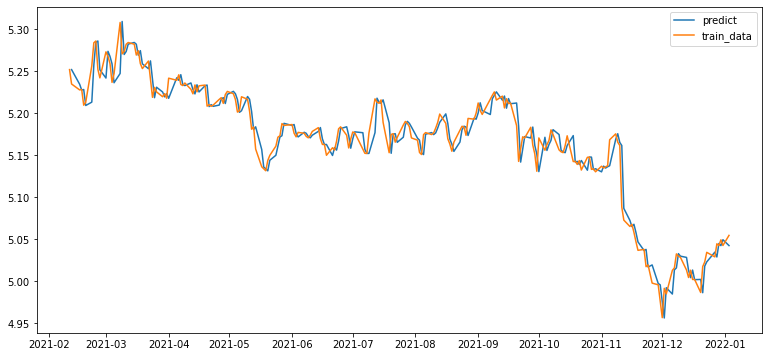

In [182]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

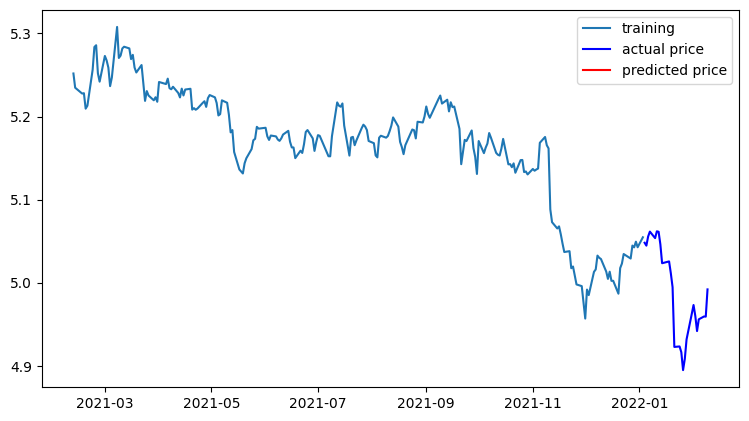

In [184]:
model = ARIMA(train_data, order=(1,1,0)) #p값 다르게
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), h=10, alpha=0.05)
#판다스 시리즈로
fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

안된다ㅜㅜ 코드에 문제가 있나보다...

그래도 시계열 데이터의 전처리에 대해서 깊게 공부할 수 있는 좋은 기회였다.

